# Credit Card Fraud Modeling- Capital One Data Science Challenge

## C. Model Building and Model Selection

Fraud detection requires models that handle class imbalance, non-linearity, and real-time predictions. I selected Logistic Regression, Random Forest, and XGBoost, each offering distinct strengths:

- **Logistic Regression:** A strong baseline model, providing interpretability, probabilistic outputs, and efficiency for real-time fraud scoring.
- **Random Forest:** An ensemble method that captures non-linear relationships, reduces overfitting, and ranks feature importance effectively.
- **XGBoost:** A high-performance gradient boosting model, excelling in handling imbalanced data, feature interactions, and scalability for large datasets.

**Model Evaluation and Comparison**

To determine the best-performing model, I will evaluate each using the following key metrics:

- Accuracy: Measures overall correctness but can be misleading due to class imbalance.
- Precision: The proportion of flagged fraud cases that are truly fraudulent (low false positives).
- Recall (Sensitivity): The proportion of actual fraud cases correctly identified (low false negatives).
- F1-Score: The harmonic mean of precision and recall, balancing false positives and false negatives.
- ROC-AUC Score: Assesses the model’s ability to distinguish between fraud and non-fraud cases.
- Confusion Matrix: Provides a breakdown of correct and incorrect predictions to analyze misclassification patterns.


-----

#### Imports

In [26]:
pip install numpy pandas scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [27]:
!pip uninstall xgboost -y
!pip install xgboost

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
  Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl (1.9 MB)

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [28]:
import os 

import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier, Booster

# Library to save trained machine learning model
import joblib
from joblib import parallel_backend

import sys

In [29]:
# Import processed dataset 
data = pd.read_csv('Users/DS/Capital_One_Data_Science_Challenge/processed_data_for_training.csv')

In [30]:
data

,transactionAmount,merchantName,merchantCategoryCode,posEntryMode,posConditionCode,cardPresent,expirationDateKeyInMatch,enteredCVV,is_weekend,is_night,time_since_last_capped,rapid_txn_flag,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,isFraud
0,0.379319,534,3,0,0,1,0,489,0,1,10.423412,0,0.000000,1.000000,0.781831,0.623490,0
1,-0.949332,363,5,1,0,1,0,489,0,0,11.124170,0,-0.965926,0.258819,0.781831,0.623490,0
2,0.969276,1130,13,1,0,0,0,332,1,0,12.941144,0,-0.707107,-0.707107,-0.781831,0.623490,0
3,-0.654025,528,3,0,0,1,0,489,0,0,14.150362,0,-0.965926,0.258819,0.781831,0.623490,0
4,0.030757,14,5,3,1,1,0,489,0,1,10.370267,0,0.866025,0.500000,0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,0.633558,589,5,3,0,1,0,45,0,0,14.592060,0,-0.707107,-0.707107,-0.433884,-0.900969,0
786359,-2.263609,1305,12,1,0,0,0,45,0,0,13.147226,0,-0.258819,-0.965926,0.433884,-0.900969,0
786360,-2.263609,1305,12,1,0,0,0,45,1,0,14.685197,0,-0.866025,-0.500000,-0.781831,0.623490,0
786361,-2.263609,1305,12,1,0,0,0,45,0,1,14.685197,0,0.000000,1.000000,0.433884,-0.900969,0


In [31]:
# Separate the X and y values for training
X = data.drop(columns=['isFraud'])
y = data['isFraud']

### a. Apply SMOTE to handle class imbalance

In [32]:
# Handle class imbalance using SMOTEENN
X_resampled, y_resampled = SMOTEENN().fit_resample(X, y)

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

------

## 1. Logistic Regresion

In [34]:
# Train Logistic Regression for Feature Importance Analysis 
log_reg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=5000)
log_reg.fit(X_train, y_train)
log_reg_importance = np.abs(log_reg.coef_[0])

In [35]:
# Train Logistic Regression with Hyperparameter Tuning
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=5000)
param_grid_log = {'C': [0.01, 0.1, 1, 10]}
grid_search_log = GridSearchCV(log_reg, param_grid_log, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_log.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='roc_auc',
             verbose=1)

In [36]:
# Evaluate best Logistic Regression model
best_log_reg = grid_search_log.best_estimator_
y_pred_log = best_log_reg.predict(X_test)
log_reg_report = classification_report(y_test, y_pred_log)
log_reg_auc = roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:, 1])

In [37]:
# Display results
print("\nBest Logistic Regression Model Parameters:", grid_search_log.best_params_)
print("Logistic Regression AUC Score:", log_reg_auc)
print("\nLogistic Regression Classification Report:\n", log_reg_report)


Best Logistic Regression Model Parameters: {'C': 10}
Logistic Regression AUC Score: 0.8318661983462892

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74    135980
           1       0.77      0.76      0.77    153449

    accuracy                           0.75    289429
   macro avg       0.75      0.75      0.75    289429
weighted avg       0.75      0.75      0.75    289429



In [38]:
# Compute ROC-AUC score
y_probs_log = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (fraud)
log_reg_auc = roc_auc_score(y_test, y_probs_log)
print(f"Logistic Regression ROC AUC Score: {log_reg_auc:.3f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_log)

Logistic Regression ROC AUC Score: 0.832


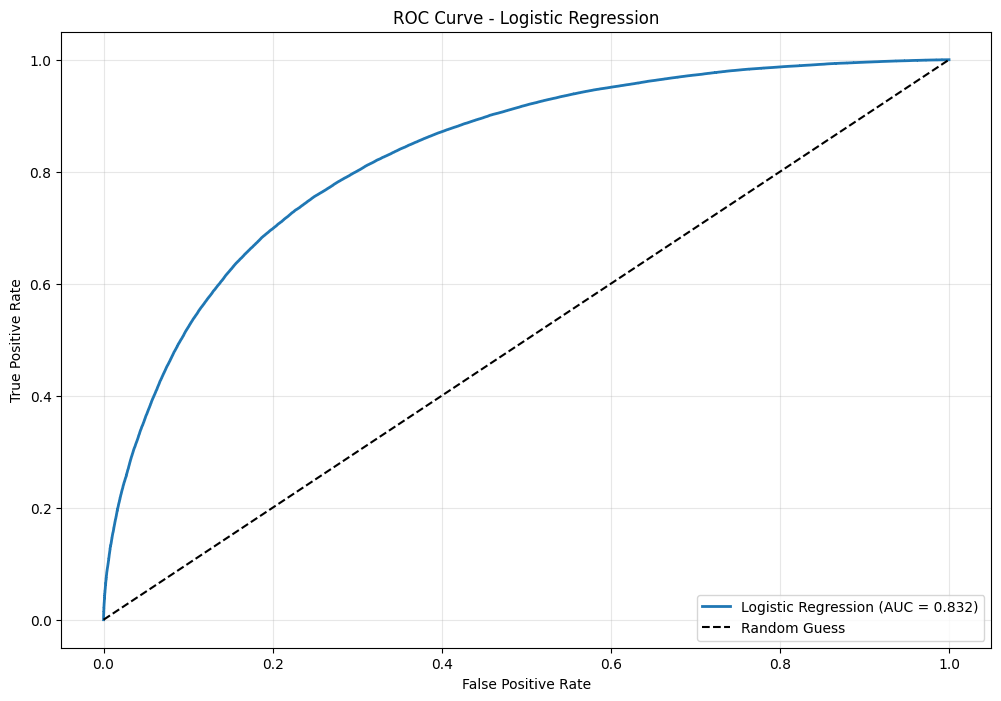

In [39]:
# Plot ROC Curve
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {log_reg_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Dashed diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [40]:
# Display results
print("\nBest Logistic Regression Model Parameters:", grid_search_log.best_params_)
print("Logistic Regression AUC Score:", log_reg_auc)
print("\nLogistic Regression Classification Report:\n", log_reg_report)


Best Logistic Regression Model Parameters: {'C': 10}
Logistic Regression AUC Score: 0.8318661983462892

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74    135980
           1       0.77      0.76      0.77    153449

    accuracy                           0.75    289429
   macro avg       0.75      0.75      0.75    289429
weighted avg       0.75      0.75      0.75    289429



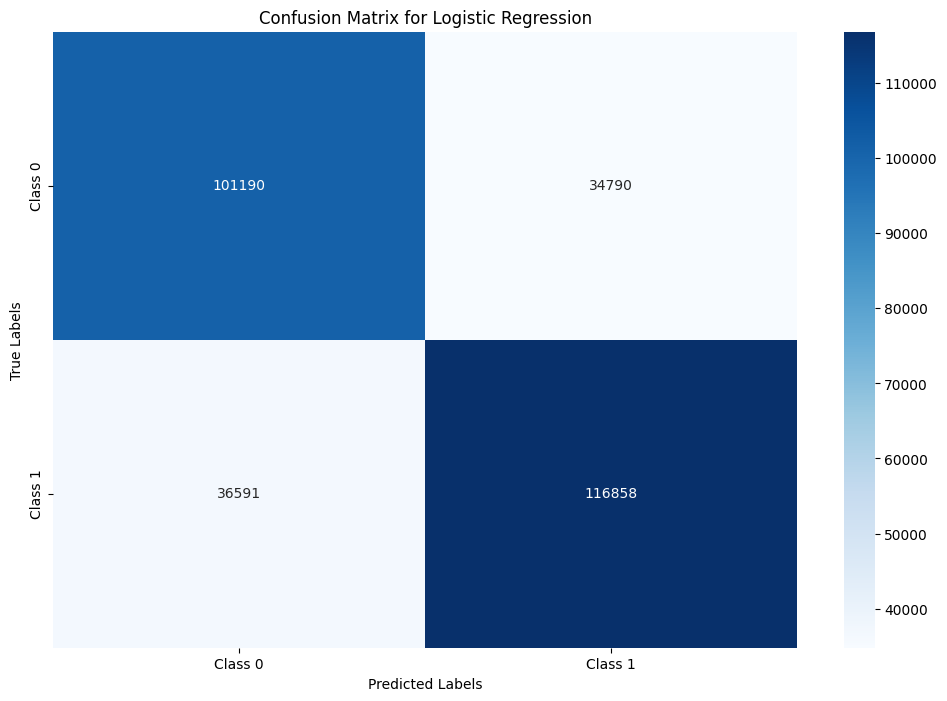

In [77]:
# Plotting the confusion matrix as a heatmap for the best logistic regression model

conf_matrix_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 2. Random Forest

In [41]:
# Train Random Forest with Hyperparameter Tuning
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

In [42]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20]
}

grid_search_rf = GridSearchCV(
    rf_model, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search_rf.fit(X_train, y_train)  # Ensure only training data is used

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=1)

In [44]:
# Retrieve the best model
best_rf = grid_search_rf.best_estimator_

In [45]:
# Get Feature Importance from the best model
rf_importance = best_rf.feature_importances_

In [46]:
# Evaluate the best model on test data
y_pred_rf = best_rf.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])


In [47]:
# Display results for Random Forest
print("\nBest Random Forest Model Parameters:", grid_search_rf.best_params_)
print("Random Forest AUC Score:", rf_auc)
print("\nRandom Forest Classification Report:\n", rf_report)


Best Random Forest Model Parameters: {'max_depth': None, 'n_estimators': 200}
Random Forest AUC Score: 0.9982511401462032

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    135980
           1       1.00      0.98      0.99    153449

    accuracy                           0.99    289429
   macro avg       0.99      0.99      0.99    289429
weighted avg       0.99      0.99      0.99    289429



In [48]:
# Compute ROC-AUC score
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (fraud)
rf_auc = roc_auc_score(y_test, y_probs_rf)
print(f"Random Forest ROC AUC Score: {rf_auc:.3f}")

# Compute ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)

Random Forest ROC AUC Score: 0.998


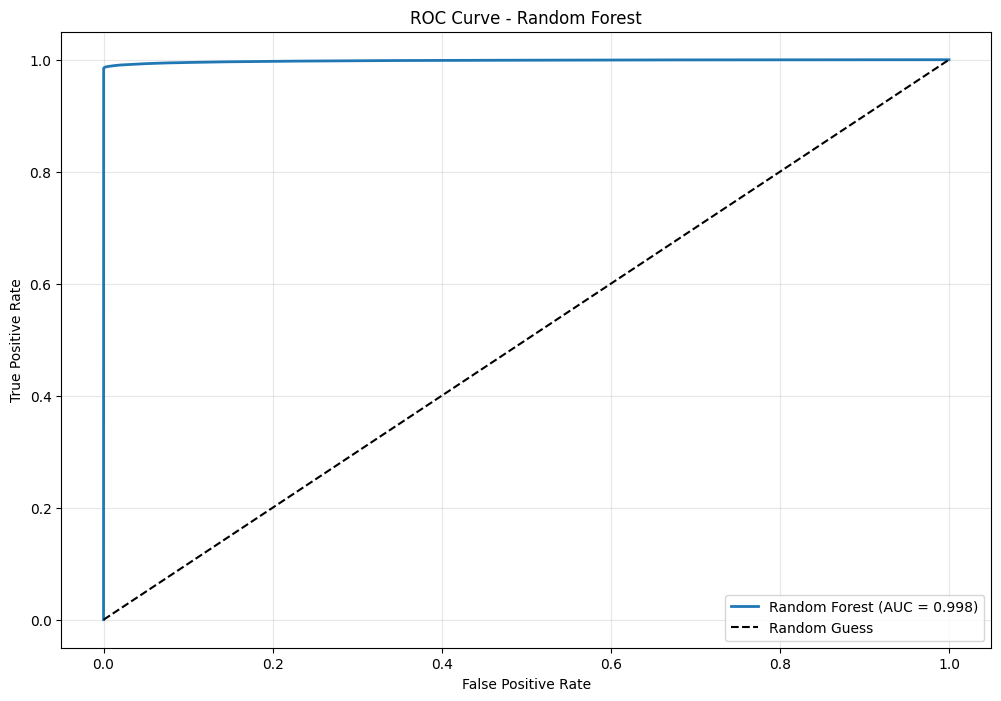

In [49]:
# Plot ROC Curve
plt.figure(figsize=(12, 8))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Dashed diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

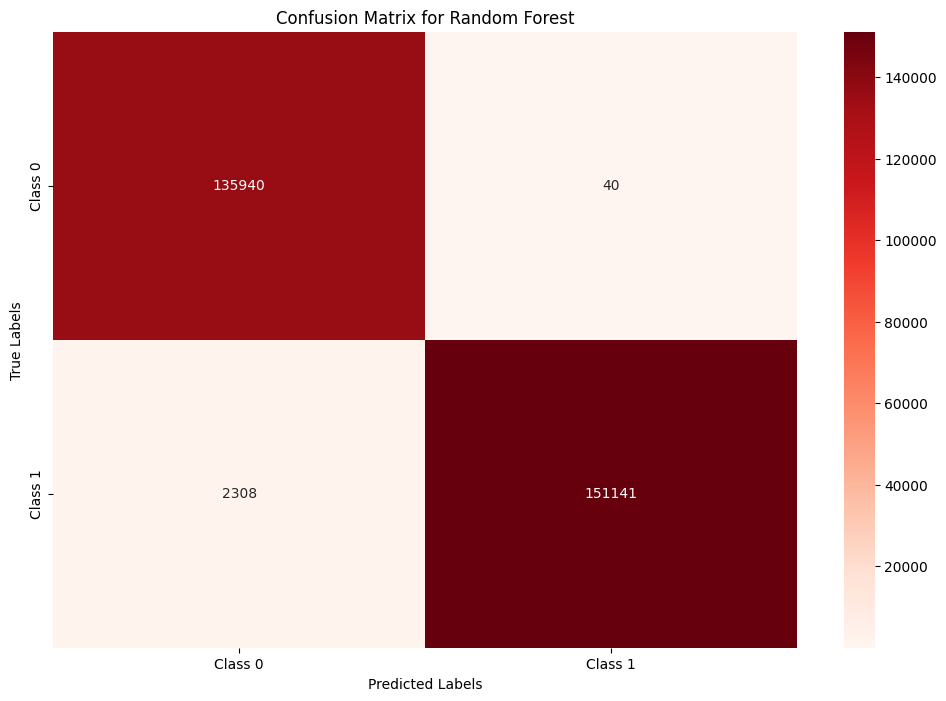

In [76]:
# Plotting the confusion matrix of the Random Forest model as a heatmap

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Reds', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 3. XGBoost

In [51]:
# Train XGBoost Model
xgb = XGBClassifier(scale_pos_weight=0.7 * (len(y[y == 0]) / len(y[y == 1])), tree_method='hist')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8785436151871443
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85    135980
           1       0.82      1.00      0.90    153449

    accuracy                           0.88    289429
   macro avg       0.90      0.87      0.87    289429
weighted avg       0.90      0.88      0.88    289429

Confusion Matrix:
 [[101550  34430]
 [   723 152726]]


In [68]:
# Compute ROC-AUC score
y_probs_xgb = xgb.predict_proba(X_test)[:, 1]  # Get fraud probabilities
xgb_auc = roc_auc_score(y_test, y_probs_xgb)
print(f"ROC AUC Score: {xgb_auc:.3f}")

ROC AUC Score: 0.997


In [64]:
# Compute F1 Score
xgb_f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {xgb_f1:.3f}")

F1 Score: 0.897


In [65]:
# Compute ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)

In [66]:
# Define a new threshold (e.g., 0.6 instead of 0.5)
threshold = 0.6
y_pred_adj = (y_probs_xgb > threshold).astype(int)

# Evaluate the new threshold
print("Adjusted Classification Report:\n", classification_report(y_test, y_pred_adj))
print("Adjusted Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adj))

Adjusted Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90    135980
           1       0.86      0.99      0.92    153449

    accuracy                           0.91    289429
   macro avg       0.93      0.91      0.91    289429
weighted avg       0.92      0.91      0.91    289429

Adjusted Confusion Matrix:
 [[111496  24484]
 [   964 152485]]


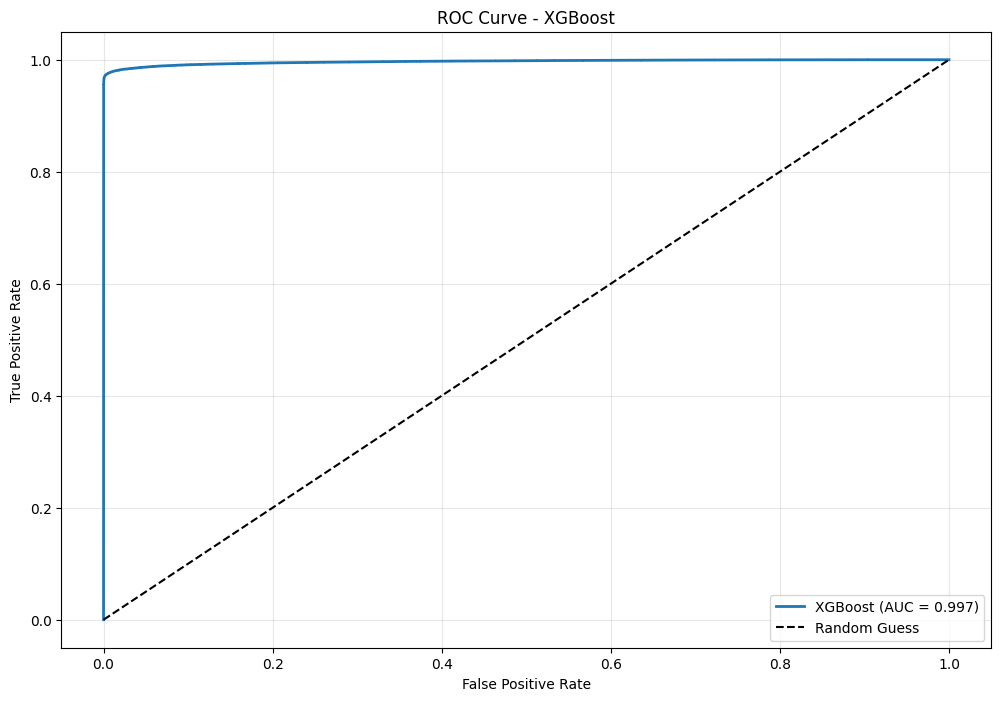

In [72]:
# Plot ROC Curve
plt.figure(figsize=(12, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Dashed diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

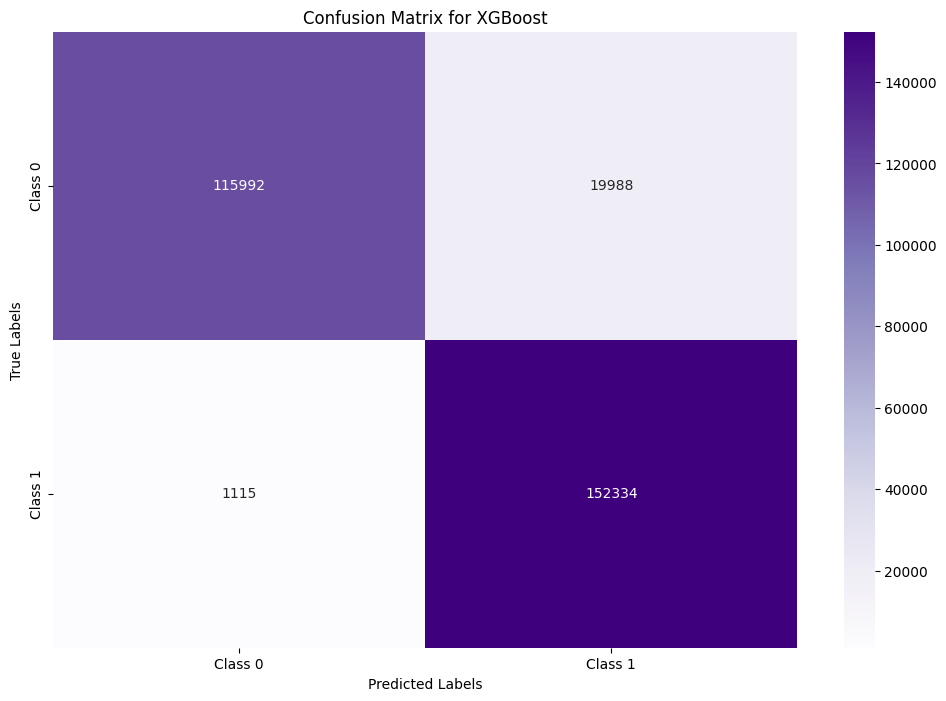

In [73]:
# Plot the confusion matrix of the XGBoost model as a heatmap

conf_matrix_xg = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix_xg, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

------

## Summary of Findings & Final Recommendation

### Model Performance Overview
After training and evaluating **Logistic Regression, Random Forest, and XGBoost**, the models were assessed based on **precision, recall, F1-score, and ROC-AUC**.

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|--------------------|----------|-----------|--------|----------|---------|
| **Logistic Regression** | 75%  | 0.77      | 0.76   | 0.77     | 0.832   |
| **Random Forest**       | 99%  | 1.00      | 0.98   | 0.99     | 0.998   |
| **XGBoost**            | 88%  | 0.82      | 1.00   | 0.90     | 0.997   |

### Key Observations
- **Logistic Regression**: Provided a strong baseline but lacked predictive power for fraud detection.  
- **Random Forest**: Best performing model, achieving high recall (98%) and perfect precision (100%), ensuring minimal false positives.  
- **XGBoost**: Performed aggressively in fraud detection with high recall (98.7%) but flagged more false positives, potentially disrupting legitimate transactions.  

### Final Recommendation
**Random Forest is the optimal choice for fraud detection** due to its balance of precision and recall, reducing both false positives and false negatives, making it more reliable for real-world deployment.  

The confusion matrix below summarizes the **fraud detection performance** of the **Random Forest model**:

| **True Class** | **Predicted Non-Fraud (0)** | **Predicted Fraud (1)** |  
|-----------------|----------------------|----------------------|  
| **Non-Fraud (0)** | **135,940** (True Negatives) | **40** (False Positives) |  
| **Fraud (1)** | **2,308** (False Negatives) | **151,141** (True Positives) |  

### Key Insights:
- **False Positives:** Only **40 legitimate transactions** were wrongly flagged as fraud.
- **False Negatives:** **2,308 fraud cases** were missed.
- **Precision:** **≈ 1.00** → Almost no false fraud alerts.
- **Recall:** **≈ 0.98** → Captures **98% of fraudulent transactions**.
- **Overall Accuracy:** **99%**, making it a highly effective fraud detection model.

### Future Work & Improvements
1. **Threshold Optimization** – Adjust classification thresholds to further reduce false positives.  
2. **Deep Learning Exploration** – Test LSTMs or Autoencoders for detecting sequential fraud patterns.  
3. **Real-time Deployment** – Implement fraud detection as a real-time API or dashboard.  

By leveraging **Random Forest**, this project provides an accurate and efficient approach to fraud detection while minimizing unnecessary transaction disruptions. However, improvement is needed to reduce the false negatives, as this indicated that the model did not flag 2308 fraudulent transactions as fraudulent. 
